In [29]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Load processed feature and label sets
X_train = pd.read_csv("../model_training/X_train.csv")
X_val = pd.read_csv("../model_training/X_val.csv")
X_test = pd.read_csv("../model_training/X_test.csv")

y_train = pd.read_csv("../model_training/y_train.csv").squeeze()
y_val = pd.read_csv("../model_training/y_val.csv").squeeze()
y_test = pd.read_csv("../model_training/y_test.csv").squeeze()

# Load preprocessing artifacts (optional)
scaler = joblib.load("../model_training/standard_scaler.pkl")
encoder = joblib.load("../model_training/ohe_encoder.pkl")


In [3]:
y_train.value_counts(normalize=True)

delay_flag
0    0.788089
1    0.211911
Name: proportion, dtype: float64

#### Lets Try Logistic Regression , we know our class seperability is not at all great, but stills lets try this and see how well our model performs 

In [4]:
lr_model = LogisticRegression(
    penalty='l2',
    class_weight='balanced',
    solver='liblinear',       # or 'saga' if using 'l1'
    max_iter=2000,
    random_state=42
)

In [5]:

lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='liblinear')

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

def evaluate(model, X, y_true, model_name="Model"):
    # Predict classes and probabilities
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_true, y_pred))

    # Print AUC
    auc = roc_auc_score(y_true, y_prob)
    print(f"{model_name} - AUC: {auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X, y_true)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()



Logistic Regression (balanced) - Train - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74     16687
           1       0.33      0.65      0.44      4487

    accuracy                           0.65     21174
   macro avg       0.60      0.65      0.59     21174
weighted avg       0.76      0.65      0.68     21174

Logistic Regression (balanced) - Train - AUC: 0.7073


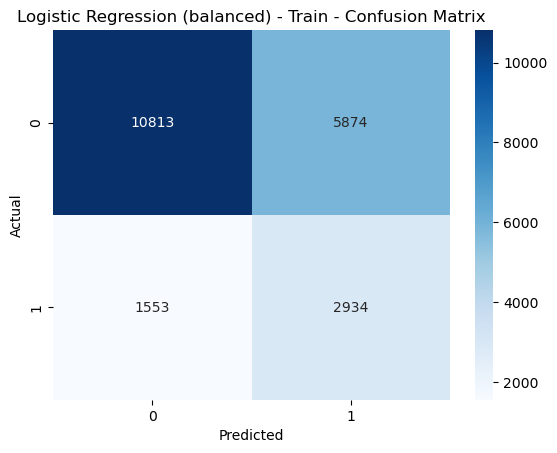

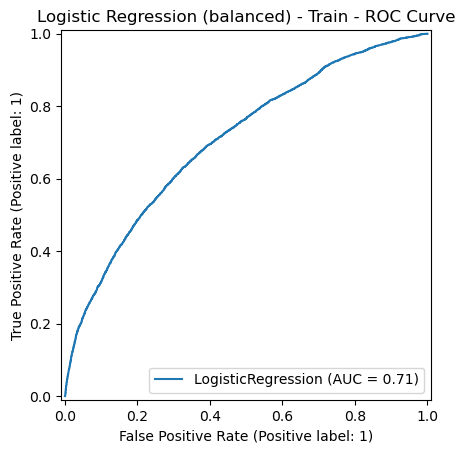

In [8]:
evaluate(lr_model, X_train, y_train, "Logistic Regression (balanced) - Train")


Logistic Regression (balanced) - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.64      0.73       835
           1       0.30      0.57      0.39       224

    accuracy                           0.62      1059
   macro avg       0.57      0.60      0.56      1059
weighted avg       0.73      0.62      0.66      1059

Logistic Regression (balanced) - AUC: 0.6542


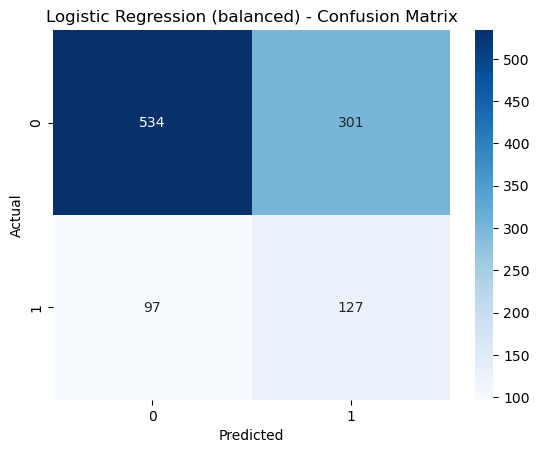

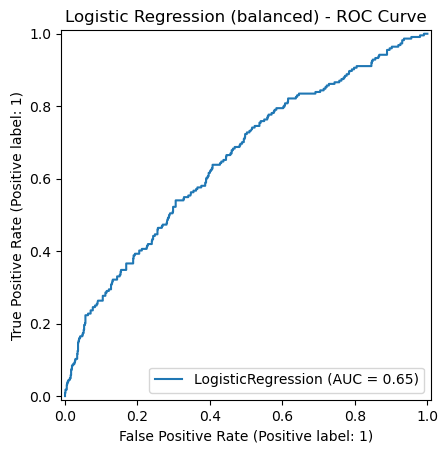

In [ ]:
evaluate(lr_model, X_val, y_val, "Logistic Regression (balanced) - Validation")

In [10]:
# Hyperparameters
# Define custom class weights
weights = [{0: 1, 1: w} for w in [1, 2, 3, 4]]

# Parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': weights,
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [2000]
}


In [11]:

# Grid search with AUC scoring
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [12]:
# Fit
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}, {0: 1, 1: 4}],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             scoring='roc_auc', verbose=2)

In [13]:
# Results
print("Best Params:", grid_search.best_params_)
print("Best AUC:", grid_search.best_score_)

Best Params: {'C': 0.01, 'class_weight': {0: 1, 1: 2}, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC: 0.6952922482027526


In [15]:
lr_model = LogisticRegression(
    penalty=grid_search.best_params_['penalty'],
    class_weight=grid_search.best_params_['class_weight'],  
    solver=grid_search.best_params_['solver'],       # or 'saga' if using 'l1'
    max_iter=grid_search.best_params_['max_iter'],  
    random_state=42,
    C=grid_search.best_params_['C'] 
)

In [16]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight={0: 1, 1: 2}, max_iter=2000,
                   random_state=42, solver='liblinear')


Logistic Regression (balanced) - Train - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     16687
           1       0.45      0.35      0.40      4487

    accuracy                           0.77     21174
   macro avg       0.64      0.62      0.63     21174
weighted avg       0.75      0.77      0.76     21174

Logistic Regression (balanced) - Train - AUC: 0.7071


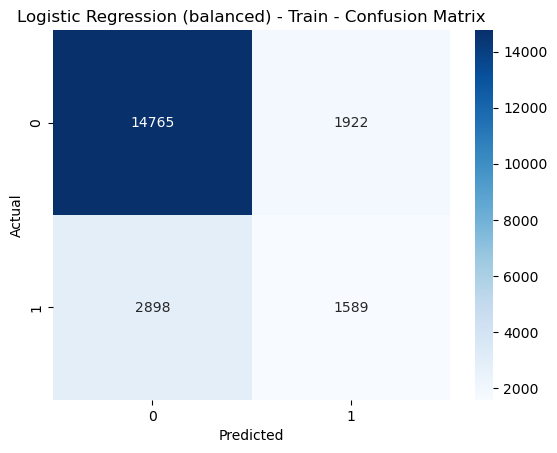

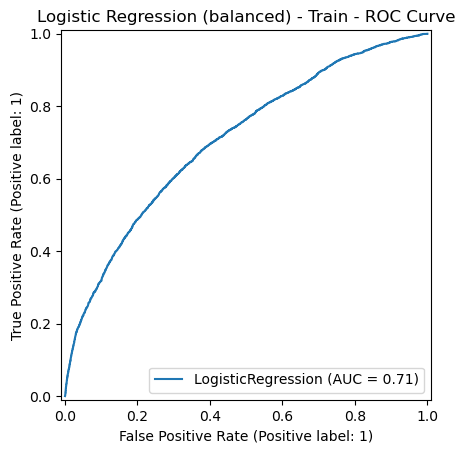

In [17]:
evaluate(lr_model, X_train, y_train, "Logistic Regression (balanced) - Train")


Logistic Regression (balanced) - Validation - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       835
           1       0.39      0.29      0.33       224

    accuracy                           0.75      1059
   macro avg       0.60      0.58      0.59      1059
weighted avg       0.73      0.75      0.74      1059

Logistic Regression (balanced) - Validation - AUC: 0.6533


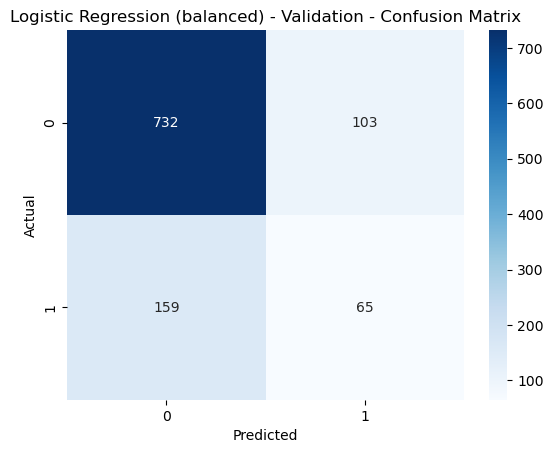

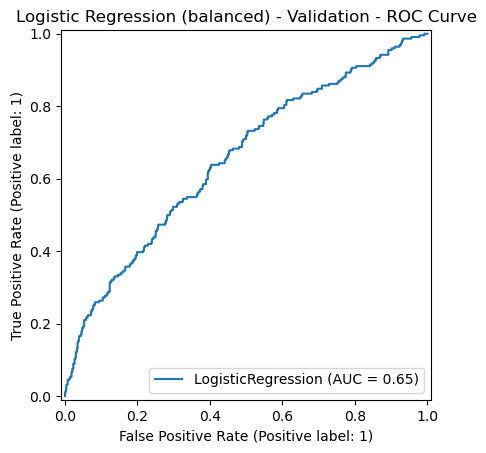

In [18]:
evaluate(lr_model, X_val, y_val, "Logistic Regression (balanced) - Validation")

In [19]:
import itertools

def manual_grid_search_auc(model_class, X_train, y_train, X_val, y_val, param_grid):
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_auc = 0
    best_model = None
    best_params = {}
    results = []

    for params in param_combinations:
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_proba)

        results.append({**params, 'val_auc': auc})

        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = params

    results_df = pd.DataFrame(results)
    return best_model, best_params, best_auc, results_df


In [20]:
# Hyperparameters
# Define custom class weights
weights = [{0: 1, 1: w} for w in [1, 2, 3, 4]]

# Parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': weights,
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [2000]
}


In [21]:
best_model, best_params, best_auc, results_df = manual_grid_search_auc(
    LogisticRegression, X_train, y_train, X_val, y_val, param_grid
)

Best AUC: 0.6541648845166809
Best Params: {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 2000}

Logistic Regression (Manual Search) - Train - Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80     16687
           1       0.37      0.55      0.44      4487

    accuracy                           0.71     21174
   macro avg       0.61      0.65      0.62     21174
weighted avg       0.76      0.71      0.72     21174

Logistic Regression (Manual Search) - Train - AUC: 0.7073


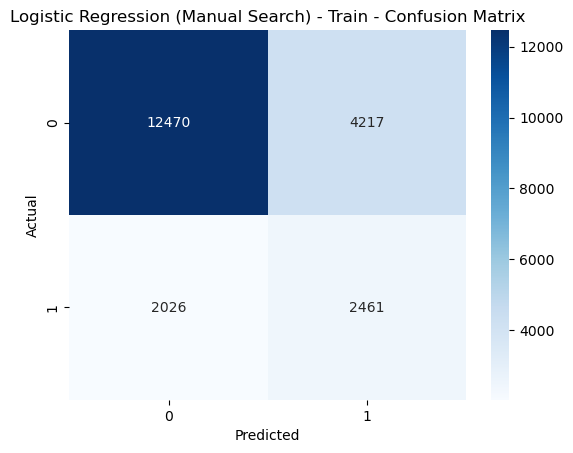

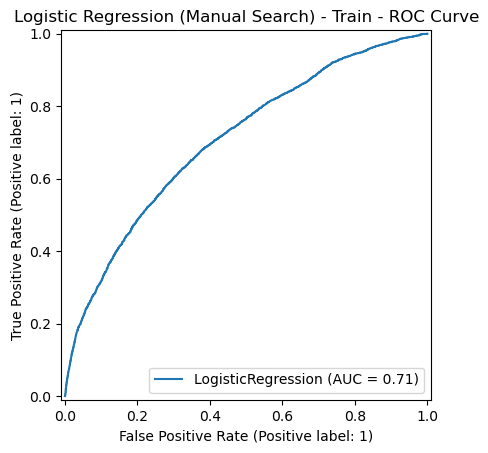


Logistic Regression (Manual Search) - Validation - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.78       835
           1       0.32      0.46      0.38       224

    accuracy                           0.68      1059
   macro avg       0.58      0.60      0.58      1059
weighted avg       0.73      0.68      0.70      1059

Logistic Regression (Manual Search) - Validation - AUC: 0.6542


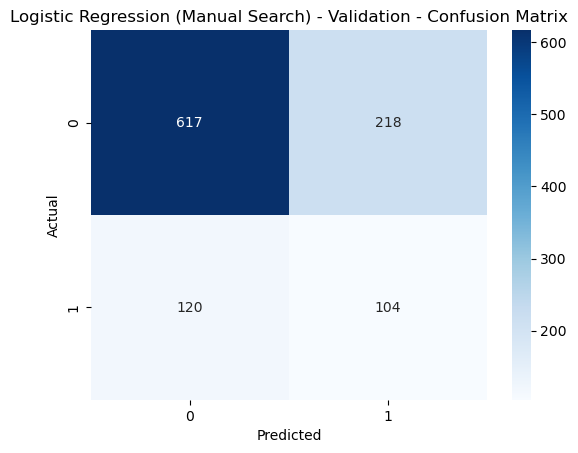

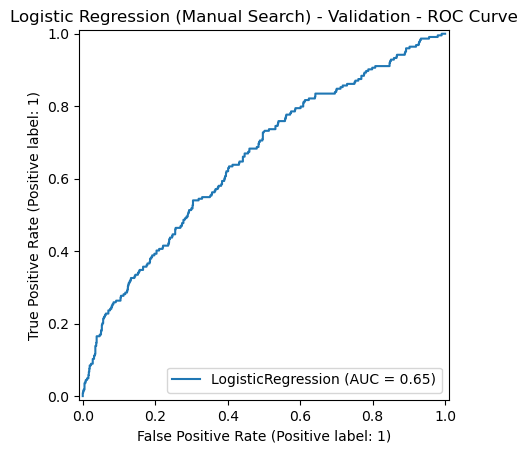

In [23]:

print("Best AUC:", best_auc)
print("Best Params:", best_params)
evaluate(best_model, X_train, y_train, "Logistic Regression (Manual Search) - Train")
evaluate(best_model, X_val, y_val, "Logistic Regression (Manual Search) - Validation")

In [26]:
coefs = best_model.coef_[0]
feature_names = X_train.columns

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_importance': np.abs(coefs)
}).sort_values(by='abs_importance', ascending=False)

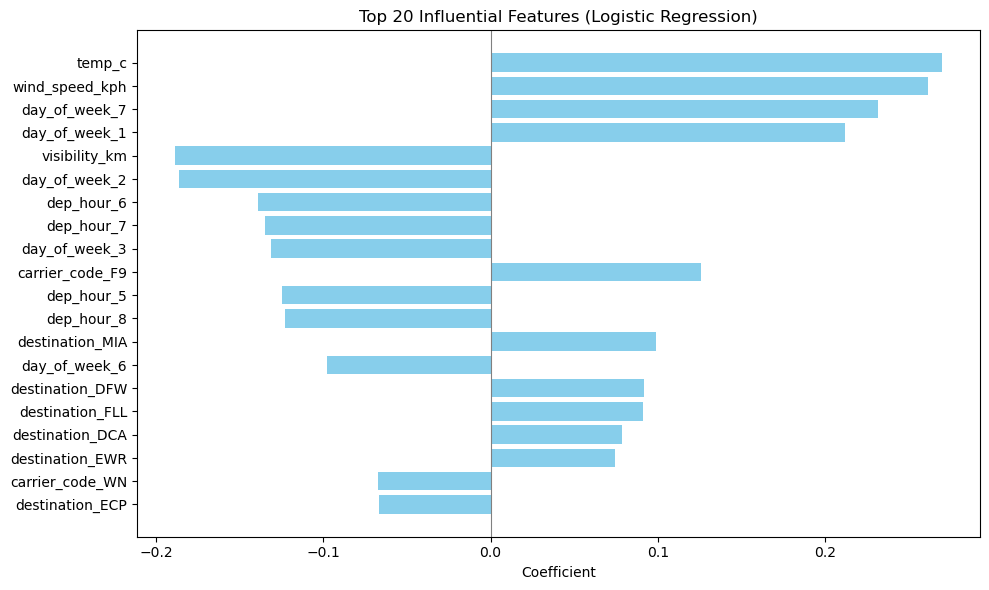

In [28]:
def plot_top_logistic_features(df, top_n=20):
    top_df = df.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_df['feature'], top_df['coefficient'], color='skyblue')
    plt.axvline(0, color='gray', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Influential Features (Logistic Regression)")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()

plot_top_logistic_features(coef_df)


###  Feature Importance Analysis — Logistic Regression

The top 20 influential features identified from the logistic regression model coefficients are summarized below:

####  Features Increasing Delay Probability (Positive Coefficients)
- **`temp_c`**: Higher temperatures are associated with increased delays.
- **`wind_speed_kph`**: Stronger wind speeds tend to increase the likelihood of delays.
- **`day_of_week_7` (Sunday)** and **`day_of_week_1` (Monday)**: Delays are more likely on these days, possibly due to traffic patterns or operational load.

####  Features Decreasing Delay Probability (Negative Coefficients)
- **`visibility_km`**: Better visibility is associated with fewer delays.
- **`dep_hour_6`, `dep_hour_7`**: Morning departure hours seem to have a lower probability of delays.
- **`day_of_week_2` (Tuesday)**: Flights on this day are less likely to be delayed compared to the reference category.

####  Carrier and Destination Influences
- **Carriers** like `carrier_code_F9`, `carrier_code_WN` show both positive and negative influence on delay probability.
- **Destinations** such as `destination_MIA`, `destination_DFW` appear to be linked with delay patterns — potentially due to airport congestion or location-specific weather issues.
> These observations help understand which features most influence the model's predictions, providing useful direction for feature selection, engineering, or further investigation.


In [34]:
rf_model = RandomForestClassifier(
    n_estimators=200,              # More trees = better generalization (to a point)
    max_depth=10,                  # Limit depth to prevent overfitting
    min_samples_split=10,         # Require at least 10 samples to split a node
    min_samples_leaf=5,           # Each leaf must have at least 5 samples
    max_features='sqrt',          # Use sqrt(n_features) at each split
    class_weight='balanced',      # Handle class imbalance
    random_state=42,
    n_jobs=-1                     # Use all cores
)


In [35]:
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)


Random Forest - Train - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81     16687
           1       0.40      0.59      0.48      4487

    accuracy                           0.72     21174
   macro avg       0.64      0.68      0.64     21174
weighted avg       0.77      0.72      0.74     21174

Random Forest - Train - AUC: 0.7453


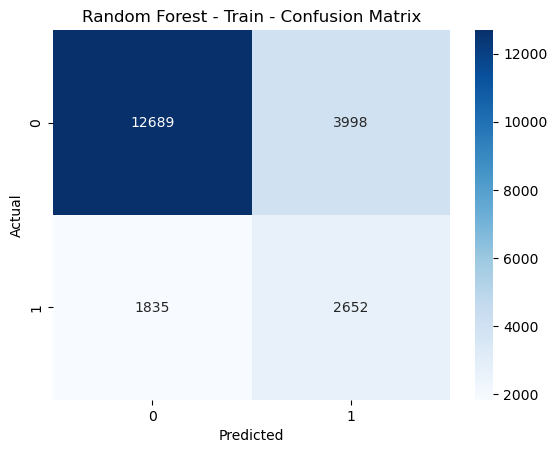

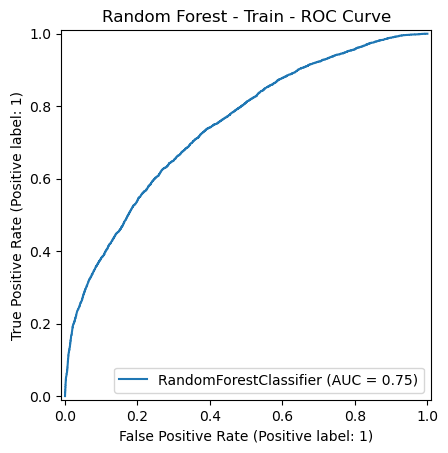


Random Forest - Validation - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       835
           1       0.34      0.49      0.40       224

    accuracy                           0.69      1059
   macro avg       0.59      0.62      0.60      1059
weighted avg       0.74      0.69      0.71      1059

Random Forest - Validation - AUC: 0.6620


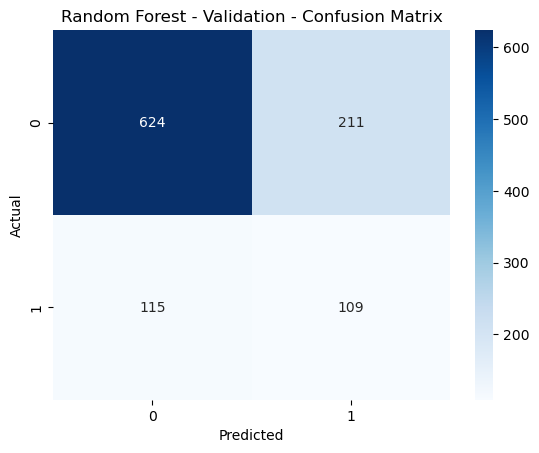

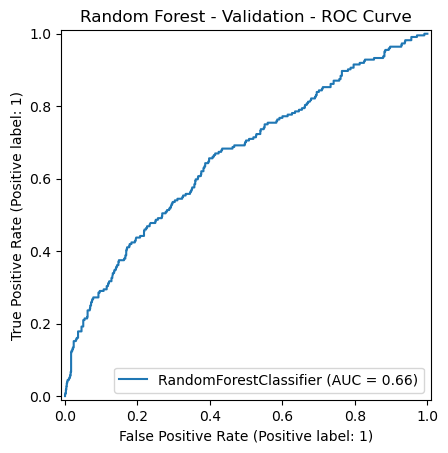

In [36]:
evaluate(rf_model, X_train, y_train, "Random Forest - Train")
evaluate(rf_model, X_val, y_val, "Random Forest - Validation")


In [37]:
from sklearn.ensemble import RandomForestClassifier

weights = [{0: 1, 1: w} for w in [1, 2, 3, 4,5]]
# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200,300,500],
    'max_depth': [10, 20,30, None],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2,4,8, 16],
    'class_weight': ['balanced'] + weights,
    'random_state': [42]
}

In [39]:
# Run tuning
best_rf_model, best_rf_auc, best_rf_params = manual_grid_search_auc(
    model_class=RandomForestClassifier,
    param_grid=rf_param_grid,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
)

KeyboardInterrupt: 

In [ ]:
evaluate(lr_model, X_train, y_train, "Random forest (balanced) - Train")    
evaluate(lr_model, X_val, y_val, "Random forest (balanced) - Validation")